In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nltk

import texthero as hero
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import demoji
from sklearn.model_selection import train_test_split, GridSearchCV
pd.set_option('display.max_colwidth', 50)

%matplotlib inline

In [2]:
df = pd.read_csv(r'C:\Users\chuaz\OneDrive\MSBA\Sem 4\BT5153\Project/comments_and_tags.csv', sep = ',', index_col = 'Unnamed: 0')
# make the 3 class problem into a binary problem
df['sentiment_binary'] = df['sentiment'].apply(lambda x: 1 if x == 1 else 0 )
df=df.reset_index()
df.head()

,index,id,sentiment,search_term,tagger,author,body,created_utc,link_id,permalink,score,subreddit,post_name,filename,sentiment_binary
0,0,glngetr,0,ladvc3,SUPRATIK,nevabraun,Thanks but you’ve lost me at \n\n„If look at A...,1612214426,t3_ladvc3,/r/wallstreetbets/comments/ladvc3/just_bought_...,21,wallstreetbets,"Just bought 860 of AMC, greetings from Germany...",comments_batch_6.csv,0
1,1,glndurd,1,ladvc3,SUPRATIK,Awake_4E,Awesome 😎! Why the moon 🤔 Let’s shoot AMC out ...,1612213448,t3_ladvc3,/r/wallstreetbets/comments/ladvc3/just_bought_...,25,wallstreetbets,"Just bought 860 of AMC, greetings from Germany...",comments_batch_6.csv,1
2,2,glndfos,1,ladvc3,SUPRATIK,Cloud9forreal,If you look at AMCs business page you’ll find ...,1612213289,t3_ladvc3,/r/wallstreetbets/comments/ladvc3/just_bought_...,58,wallstreetbets,"Just bought 860 of AMC, greetings from Germany...",comments_batch_6.csv,1
3,3,glnd58d,1,ladvc3,SUPRATIK,MacCoy69,"I bought 20 today, i am also a retarded dumb m...",1612213186,t3_ladvc3,/r/wallstreetbets/comments/ladvc3/just_bought_...,13,wallstreetbets,"Just bought 860 of AMC, greetings from Germany...",comments_batch_6.csv,1
4,4,glnd2xt,1,ladvc3,SUPRATIK,Menuler,"Ahh, my fellow Retard. I see the more and more...",1612213163,t3_ladvc3,/r/wallstreetbets/comments/ladvc3/just_bought_...,11,wallstreetbets,"Just bought 860 of AMC, greetings from Germany...",comments_batch_6.csv,1


In [3]:
def find_pos(word):
    # Part of Speech constants
    # ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
    pos= nltk.pos_tag(nltk.word_tokenize(word))[0][1]
    # Adjective tags -'JJ', 'JJR', 'JJS'
    if pos.lower()[0] == 'j':
        return 'a'
    # Adverb tags -'RB', 'RBR', 'RBS'
    elif pos.lower()[0] == 'r':
        return 'r'
    # Verb tags -'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'
    elif pos.lower()[0] == 'v':
        return 'v'
    # Noun tags -'NN', 'NNS', 'NNP', 'NNPS'
    else:
        return 'n'

demoji.download_codes()

def remove_emoji(text):
    dem = demoji.findall(text)
    for item in dem.keys():
        text = text.replace(item,'')
        
    return text

# Function to apply lemmatization to a list of words
def words_lemmatizer(text, encoding="utf8"):
    words = nltk.word_tokenize(text)
    lemma_words = []
    wl= WordNetLemmatizer()
    for word in words:
        pos= find_pos(word)
        lemma_words.append(wl.lemmatize(word, pos))
    return " ".join(lemma_words)

def remove_stopwords(text, lang='english'):
    new_words = ['already','also','comment','delete','even','literally','lolol','lololol','lolz','lols','lot','loll','lolololol','lolll','mean','na',
                 'point','post','probably','put','reddit','remove','see','something','want','well'] #first 200 in dictionary_all #insert all additional stopwords you want to remove here 
    custom = nltk.corpus.stopwords.words('english')
    custom.extend(new_words)
    words = nltk.word_tokenize(text)
    lang_stopwords = stopwords.words(lang)
    stopwords_removed = [w for w in words if w.lower() not in lang_stopwords]
    removing_custom_words = [words for words in stopwords_removed if not words in custom]
    return " ".join(removing_custom_words)

def do_preprocessing(one_row):
    lower_text = one_row.lower()
    
    remove_url = re.sub(r'http\S+', '',lower_text) # Remove URL
    
    remove_emoji_text = remove_emoji(remove_url) # Remove emojis

    remove_unwanted_charectors = re.sub(r'[^a-zA-Z0-9_#@&\s]', ' ', remove_emoji_text) # Remove unwanted charectors like punctuations andnon ascii 
    remove_unwanted_charectors = re.sub(r'&[\w]+', ' ', remove_unwanted_charectors) # Remove &amp, *&words etc
    
    removed_extra_space = re.sub(r'\s+',' ', remove_unwanted_charectors) # Remove extra white_spaces
    
    extract_hash = re.findall(r'#[\w]+', removed_extra_space) # Extract #hashTags
    extract_has_joined = " ".join(extract_hash)
    removed_hash_text = re.sub(r'#[\w]+', '', removed_extra_space) # Remove #hastags
    
    remove_atrate = re.findall(r'@[\w]+', removed_hash_text) # Extract @Users
    removed_atrate = re.sub(r'@[\w]+', '', removed_hash_text) # Remove @Users
    
    removed_stopwords_text = remove_stopwords(removed_atrate)
    lemmatize_text = words_lemmatizer(removed_stopwords_text)
    return lemmatize_text

C:\ProgramData\Anaconda3\envs\5153env\lib\site-packages\ipykernel_launcher.py:18: FutureWarning:

The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.



In [4]:
# Preprocessing

df['body'] = df['body'].astype(str)
df['body'] = df['body'].apply(do_preprocessing)

In [5]:
from nltk.corpus import stopwords

top_n =250

#create new df with only body and sentiment
dfNew = df[['body','sentiment_binary']]

# create sparse matrix with 1-gram and 2-gram
stop = set(stopwords.words('english'))
corpus = dfNew.loc[:,'body']
tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words=list(stop), max_features= top_n)
vectorized = tfidf.fit_transform(corpus)

#convert to dense matrix
vocab = tfidf.get_feature_names()
df_vectorized= pd.DataFrame(vectorized.todense(),columns=vocab)

# combine with dfNew
df_combined = pd.concat([dfNew, df_vectorized], axis=1)

In [6]:
X = df_combined.drop(['body','sentiment_binary'],axis=1)
y = df_combined['sentiment_binary']

## PCA

In [34]:
from sklearn.decomposition import PCA
for i in [5,10,15,20,25,30,40,50]:
    pca = PCA(n_components=i)
    principalComponents = pca.fit_transform(df_vectorized)
    print(i)
    print(pca.explained_variance_ratio_.cumsum()[-1])


5
0.10530629027339233
10
0.17067566479330487
15
0.223155569405118
20
0.26821610621533765
25
0.3067740284098422
30
0.34320609104484506
40
0.40839777602204935
50
0.4658805044666738


In [35]:
pca = PCA(n_components=50)
principalComponents = pca.fit_transform(df_vectorized)
X_train, X_test, y_train, y_test = train_test_split(principalComponents, y, test_size=0.3, random_state=1, stratify =y)

In [36]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=False, predictions = True, custom_metric = None, random_state = 42 )
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)
# this is the score for top 250 terms + PCA

 14%|███████████▍                                                                       | 4/29 [00:04<00:28,  1.14s/it]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


 90%|█████████████████████████████████████████████████████████████████████████▌        | 26/29 [00:14<00:01,  1.90it/s]

StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.66               0.66     0.66      0.66   
RandomForestClassifier             0.66               0.66     0.66      0.66   
XGBClassifier                      0.65               0.65     0.65      0.65   
ExtraTreesClassifier               0.65               0.64     0.64      0.65   
LogisticRegression                 0.65               0.64     0.64      0.65   
LinearSVC                          0.65               0.64     0.64      0.64   
RidgeClassifierCV                  0.65               0.64     0.64      0.64   
CalibratedClassifierCV             0.65               0.64     0.64      0.64   
RidgeClassifier                    0.65               0.64     0.64      0.64   
LinearDiscriminantAnalysis         0.65               0.64     0.64      0.64   
SVC                         

In [79]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)
from sklearn.metrics import precision_score
precision_score(y_test, pred)

0.6363636363636364

## UMAP

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
%matplotlib inline
import umap

In [27]:
data = df_vectorized
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=y)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=y)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=y, s=100)
    plt.title(title, fontsize=18)

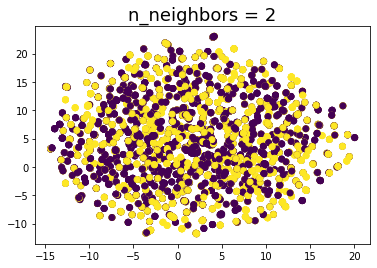

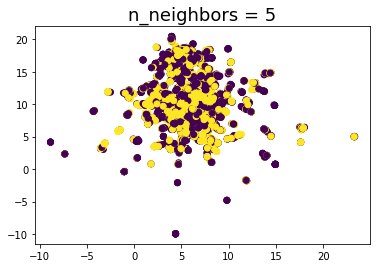

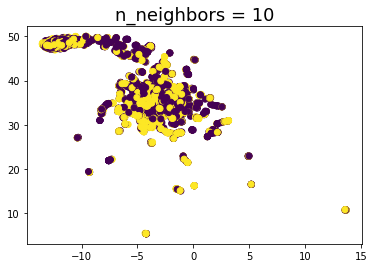

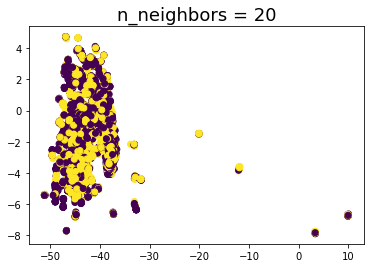

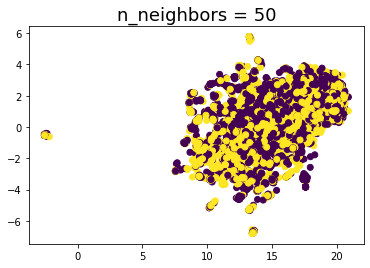

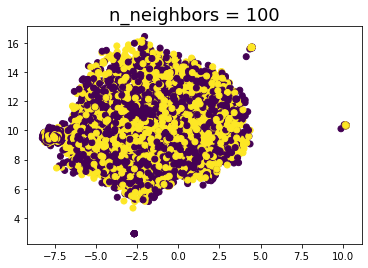

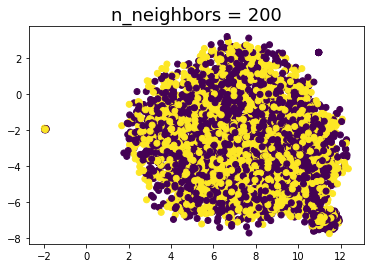

In [21]:
for n in (2, 5, 10, 20, 50, 100, 200):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

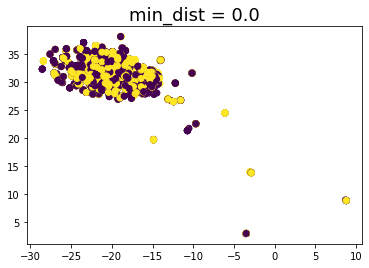

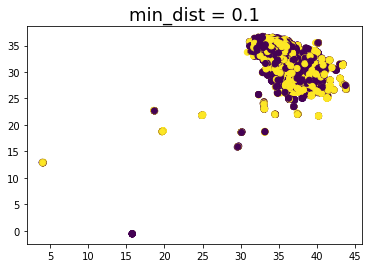

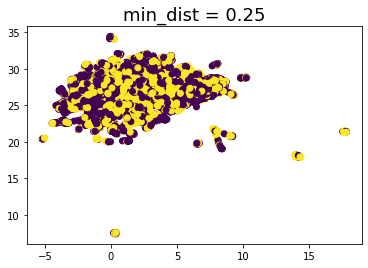

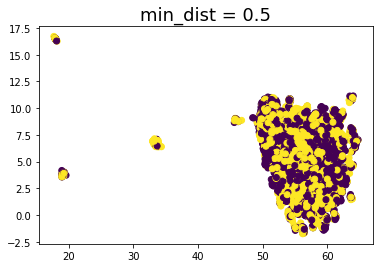

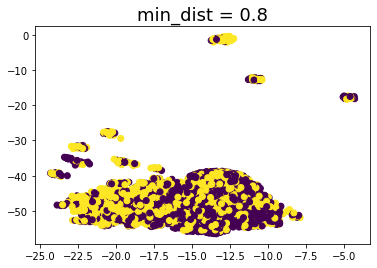

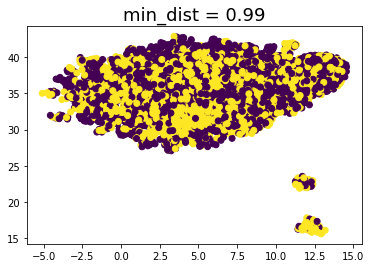

In [28]:
for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

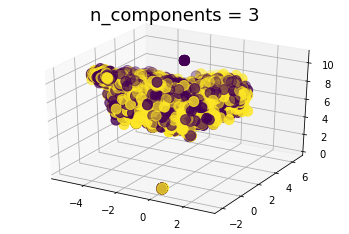

In [23]:
draw_umap(n_neighbors = 200,n_components=3, title='n_components = 3')

In [24]:
reducer = umap.UMAP()
umap = reducer.fit_transform(df_vectorized)
X_train, X_test, y_train, y_test = train_test_split(umap, y, test_size=0.3, random_state=1, stratify =y)

In [30]:
import lazypredict
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=False, predictions = True, custom_metric = None, random_state = 42 )
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

C:\Users\chuaz\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\deprecation.py:143: FutureWarning:

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.

 14%|███████████▍                                                                       | 4/29 [00:00<00:04,  5.09it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


 90%|█████████████████████████████████████████████████████████████████████████▌        | 26/29 [00:04<00:00,  6.05it/s]

StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.47it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
KNeighborsClassifier               0.60               0.59     0.59      0.59   
LabelPropagation                   0.59               0.58     0.58      0.58   
ExtraTreesClassifier               0.58               0.58     0.58      0.58   
LGBMClassifier                     0.58               0.58     0.58      0.58   
LabelSpreading                     0.58               0.58     0.58      0.58   
XGBClassifier                      0.58               0.57     0.57      0.58   
RandomForestClassifier             0.58               0.57     0.57      0.57   
BaggingClassifier                  0.57               0.57     0.57      0.57   
AdaBoostClassifier                 0.57               0.57     0.57      0.57   
SVC                                0.56               0.56     0.56      0.56   
ExtraTreeClassifier         